In [25]:
import zipfile
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2 as cv
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
import matplotlib.pyplot as plt
from cv2 import CascadeClassifier
from tensorflow.keras import applications
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.regularizers import l2

Dataset creato da immagini di 3 attori diversi e organizzato in sottocartelle per ogni classe


In [2]:
zip = zipfile.ZipFile('/Actors.zip')
zip.extractall()
zip.close()

## Data augmentation del dataset originale


Operations performed: rotation, flip, brightness

In [3]:
def data_aug():
#for each folder in actors directory perform data augmentation
    #data generator
    datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest', horizontal_flip=True, brightness_range=[0.7,1.2])
    iterator = datagen.flow_from_directory("./Actors", color_mode="rgb", batch_size=1, class_mode="categorical")

    for f in sorted(os.listdir('./Actors/Bradley')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Bradley/' + f)
            img = img_to_array(img)
            img = expand_dims(img, 0)
            iterator = datagen.flow(img, batch_size=1)
            # generate samples
            for i in range(9):
                # generate batch of images
                batch = iterator.next()
                # convert to unsigned integers
                image = batch[0].astype('uint8')
                f = f.replace(".jpg", "")
                cv.imwrite('/content/Actors/Bradley/' + f + "_" + str(i) + ".jpg", image)

    for f in sorted(os.listdir('./Actors/Leonardo')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Leonardo/' + f)
            img = img_to_array(img)
            img = expand_dims(img, 0)
            iterator = datagen.flow(img, batch_size=1)
            # generate samples
            for i in range(9):
                # generate batch of images
                batch = iterator.next()
                # convert to unsigned integers
                image = batch[0].astype('uint8')
                f = f.replace(".jpg", "")
                cv.imwrite('/content/Actors/Leonardo/' + f + "_" + str(i) + ".jpg", image)

    for f in sorted(os.listdir('./Actors/Toretto')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Toretto/' + f)
            img = img_to_array(img)
            img = expand_dims(img, 0)
            iterator = datagen.flow(img, batch_size=1)
            # generate samples
            for i in range(9):
                # generate batch of images
                batch = iterator.next()
                # convert to unsigned integers
                image = batch[0].astype('uint8')
                f = f.replace(".jpg", "")
                cv.imwrite('/content/Actors/Toretto/' + f + "_" + str(i) + ".jpg", image)


Final dataset records: 65 x 10 = 650

In [4]:
data_aug()

Found 65 images belonging to 3 classes.


Example of data augmentation

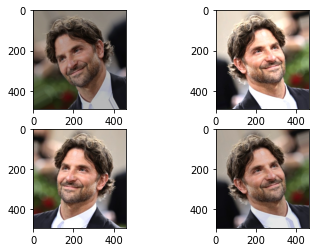

In [5]:
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
plt.subplot(2,2,1)
plt.imshow(mpimg.imread(("/content/Actors/Bradley/19_1.jpg")))
plt.subplot(2,2,2)
plt.imshow(mpimg.imread(("/content/Actors/Bradley/19_2.jpg")))
plt.subplot(2,2,3)
plt.imshow(mpimg.imread(("/content/Actors/Bradley/19_3.jpg")))
plt.subplot(2,2,4)
plt.imshow(mpimg.imread(("/content/Actors/Bradley/19_4.jpg")))

## Data loader + face detection

In [12]:
def face_detection(img):
    # funzione che data un'immagine ritorna solamente il crop della faccia che trova al suo interno
    classifier = CascadeClassifier('/haarcascade_frontalface_default.xml')
    box = classifier.detectMultiScale(img, minNeighbors=30)
    #se non trova nessuna faccia non ritorna niente
    (x,y,w,h) = (0,0,0,0)
    if box is ():
        return None
    #altrimenti ritorna solo la prima faccia
    else:
        (x,y,w,h) = box[0]
        return cv.resize(img[y:y+h, x:x+w, :], (224,224))

In [7]:
def load_data():
    # funzione che per con le immagini crea il dataset di train e test applicando prima la funzione di face detection
    labels = []
    images = []

    for f in sorted(os.listdir('./Actors/Bradley')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Bradley/' + f)
            img = (face_detection(img))
            #se il face detector trova un'immagine allora la aggiunge al dataset
            if img is not None:
                images.append(img)
                # lable
                labels.append("Bradley")

    for f in sorted(os.listdir('./Actors/Leonardo')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Leonardo/' + f)
            img = (face_detection(img))
            if img is not None:
                images.append(img)
                # lable
                labels.append("Leonardo")

    for f in sorted(os.listdir('./Actors/Toretto')):
        if f.endswith('.jpg'):
            img = cv.imread('/content/Actors/Toretto/' + f)
            img = (face_detection(img))
            if img is not None:
                images.append(img)
                # lable
                labels.append("Toretto")

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=1)
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = load_data()

Lables to categorical

In [18]:
y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

Esempio di face detection

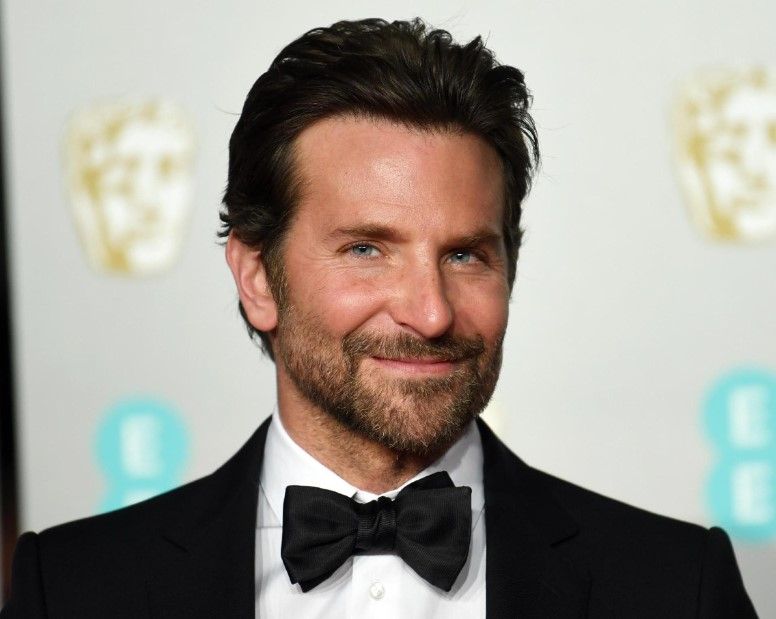

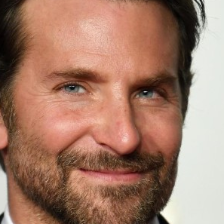

In [16]:
from google.colab.patches import cv2_imshow
img = cv.imread("/content/Actors/Bradley/1.jpg")
cv2_imshow(img)
img = face_detection(img)
cv2_imshow(img)

# CNN training with transporter NN

Utilizzo come base la NN EfficientNetB7

In [19]:
base_net = applications.EfficientNetB7(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

258088960/258076736 [==============================] - 1s 0us/step


In [20]:
#Non alleno i layer importati dalla rete
for layer in base_net.layers:
    layer.trainable = False

Crezione architettura

In [49]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# preprocessing dell'immagine ottimizzata per efficientnet
x = applications.efficientnet.preprocess_input(x)
x = base_net(x)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)

outputs = keras.layers.Dense(3, activation='softmax')(x)

In [50]:
net = keras.Model(inputs=inputs, outputs=outputs)

Fase training

In [51]:
net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

In [52]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [53]:
"""checkpoint = ModelCheckpoint("./models", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]"""
history = net.fit(x=X_train, y=y_train, epochs=25, validation_split=0.2, verbose=1);

Epoch 1/25
9/9 [==============================] - 27s 999ms/step - loss: 3.4110 - accuracy: 0.5172 - val_loss: 2.3852 - val_accuracy: 0.5152
Epoch 2/25
9/9 [==============================] - 4s 426ms/step - loss: 1.6785 - accuracy: 0.8008 - val_loss: 1.5447 - val_accuracy: 0.8333
Epoch 3/25
9/9 [==============================] - 4s 491ms/step - loss: 1.2551 - accuracy: 0.9004 - val_loss: 1.2027 - val_accuracy: 0.8636
Epoch 4/25
9/9 [==============================] - 4s 494ms/step - loss: 1.1778 - accuracy: 0.9080 - val_loss: 1.0825 - val_accuracy: 0.8939
Epoch 5/25
9/9 [==============================] - 4s 429ms/step - loss: 0.8746 - accuracy: 0.9693 - val_loss: 2.2896 - val_accuracy: 0.5303
Epoch 6/25
9/9 [==============================] - 4s 429ms/step - loss: 1.1913 - accuracy: 0.8467 - val_loss: 0.7040 - val_accuracy: 0.9697
Epoch 7/25
9/9 [==============================] - 4s 428ms/step - loss: 0.6467 - accuracy: 0.9962 - val_loss: 3.5096 - val_accuracy: 0.5758
Epoch 8/25
9/9 [===

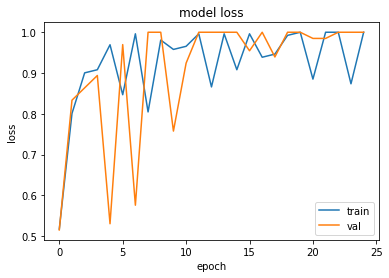

In [57]:
#plot the viz of train and val error
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Evaluation

In [58]:
net.evaluate(X_test, y_test)

2/2 [==============================] - 0s 79ms/step - loss: 0.2056 - accuracy: 1.0000


[0.20556962490081787, 1.0]

# Feature explanation with LIME


In [ ]:
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

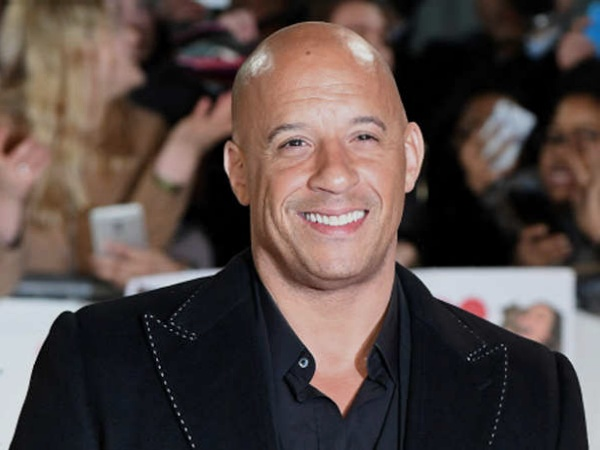

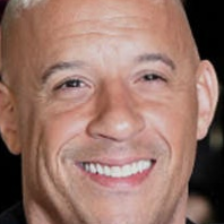

In [102]:
# immagine di test per mostrare heatmap
from google.colab.patches import cv2_imshow
img = cv.imread("/content/Actors/Toretto/46_2.jpg")
cv2_imshow(img)
img = face_detection(img)
cv2_imshow(img)
img = np.expand_dims(img, axis=0).astype(np.float32)

Configurazione LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

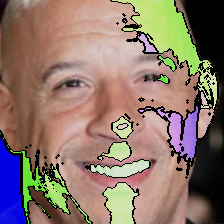

In [105]:
preds = net.predict(img)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img[0].astype('double'), net.predict,  top_labels=1, hide_color=0, num_samples=1000)

temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

cv2_imshow(mark_boundaries(temp_2, mask_2, color=(0,1,0)))